# Accessing Global High Quality GEDI Measurements

This document goes through accessing global high quality GEDI measurements throughout whole time series. This version covers data from 2019-03-25 to 2022-12-21. In order to extract high quality GEDI points. In the pre-filtering process, GEDI points are excluded if

-  GEDI shots with `Quality Flag` equal to 0
-  `Degradation Flag` larger than 0
-  `Sensitivity` smaller than 0.98

Furthermore, most used waveform attributes are extracted:

- `Elev_lowestmode` - a GEDI estimate of the terrain height (absolute height from the WGS84 ellipsoid, EGM 2008) 
- `RH-values` - the relative height values for the energy levels of: 25%, 50%,75%, 98%, 99%, and 100%

accompanying with auxiliary information:

- `Date` in %mm%dd%yy as Integer
- `Geometry` in the proejction EPSG:4326


![gedi_overview.png](img/gedi_overview.png)

## Step 1: Setting up

### Load in required packages

 Let's start importing the necessary modules.

In [1]:
import os
import pandas as pd
import numpy as np

from pyarrow import fs
import pyarrow.parquet as pq

from shapely.geometry import shape
from shapely import wkb
import geopandas as gpd

from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl
import contextily as cx

### Connect to remote S3 server

To access the files it's necessary create the S3FileSystem pointing to directly to http://s3.eu-central-1.wasabisys.com without the need to provide any credentials. After that it's possible access data from a remote server to your local machine, then you can analysis or export at your disposal

In [2]:
scheme = 'https'
endpoint = "s3.eu-central-1.wasabisys.com"
bucket = 'gedi-ard'
httpfs = fs.S3FileSystem(scheme=scheme, endpoint_override=endpoint)

## Step 2: Data access

### Global overview table

The global overview shows above can be accessed at the address: http://s3.eu-central-1.wasabisys.com/gedi-ard/tiling.fgb (Double click to download). 

Overview is tiled one degree by one degree in longitude and latitude. This overview is not only used as an outlook but also for geospatial filter. Therefore we load in here at our disposal

In [3]:
lookup_table = gpd.read_file('http://s3.eu-central-1.wasabisys.com/gedi-ard/lookup.fgb')
lookup_table.head()

,name,count,geometry
0,179E_49S,18,"POLYGON ((180.00000 -9.00000, 180.00000 -8.000..."
1,179E_19S,3878,"POLYGON ((180.00000 -9.00000, 180.00000 -8.000..."
2,179E_09S,302,"POLYGON ((180.00000 -9.00000, 180.00000 -8.000..."
3,179E_29S,44,"POLYGON ((180.00000 -9.00000, 180.00000 -8.000..."
4,179E_39S,919,"POLYGON ((180.00000 -9.00000, 180.00000 -8.000..."


### Defining area of interest

Here we use leaflet plug-in in Python to browser the area of interest. The interactive map enables scrolling and drawing polygon and export the geometry. 

To be noticed, the whole database of high quality GEDI measurements reaches over 10GB while selecting a big area.

In [4]:
mapnik = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
mapnik.base = True
mapnik.name = 'Mapnik Layer'

esri = basemap_to_tiles(basemaps.Esri.WorldImagery)
esri.base = True
esri.name = 'ESRI Imagery Layer'

m = Map(center=(24,121.5), zoom = 7, layers = [esri, mapnik])

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillOpacity": 0,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[24, 121.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

After defining the polygon on the leaflet map, `drawcontrol` allows to export the information of polygon and `shapely.shape` turns into a geometry attribute. In addition, we use `Geopandas` to transform geometry into `Geopandas.GeoDataFrame` in order to implement geospatial filter.

In [5]:
geometry = shape(draw_control.data[-1]['geometry'])
aoi = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')

### Geospatial filter

Combining overview with defined polygon (aoi), `Geopandas.overlay` extracts data intersects between two GeoDataFrame. So far, you retrieve the subset of polygons in overview that intersect with your aoi, with three information: 

- Name: degree of the tile
- Count: number of points in the 1x1 degree cell
- Geometry: intersected polygon. To be noticed, the polygons here might not be tetragon because they could be cut by your aoi.

In [6]:
intersection_gdf = gpd.overlay(lookup_table, aoi, how='intersection')

In [7]:
intersection_gdf

,name,count,geometry
0,120E_24N,69249,"POLYGON ((120.68072 24.00000, 120.81729 24.241..."
1,120E_23N,109677,"POLYGON ((121.00000 23.69043, 120.49755 23.675..."
2,121E_23N,149452,"POLYGON ((121.00000 23.87599, 121.12704 23.694..."


## GEDI measurements extraction

So far, you have a list of 1x1 degree tile of GEDI measurements that you are interested in. Subsequently, you should point it to the remote server that you have set up at the beginning, and directly retrieve data from it. It should be as a matter of time if total points are less than 1 million. `ParquetDataset` stores geometry as Well-Known Binary(WKB), you can simply translate into Well-known text(Wkt) in a line of code.

Later on, let's concatenate data into a GeoDataFrame again and set crs as `EPSG:4326` as it used to be

In [8]:
output_df = []
for file in intersection_gdf.name:
    data = pq.ParquetDataset(f'{bucket}/data/{file}.pq', filesystem=httpfs).read().to_pandas()
    data['geometry'] = data['geometry'].apply(lambda x: wkb.loads(x))
    output_df.append(data)

In [9]:
output_gdf = gpd.GeoDataFrame(
    pd.concat(output_df), geometry=pd.concat(output_df).geometry, crs="EPSG:4326"
)

In [10]:
gedi_aoi = gpd.overlay(output_gdf, aoi, how='intersection')
gedi_aoi.crs = output_gdf.crs

In [11]:
gedi_aoi.head()

,date,lowestmode,rh100,rh99,rh98,rh75,rh50,rh25,geometry
0,20190618,321.221252,23.370001,22.620001,22.100000,10.45,10.45,7.45,POINT (120.75677 24.12886)
1,20190618,233.450729,15.500000,14.680000,14.270000,7.15,7.15,4.30,POINT (120.75860 24.12689)
2,20190618,219.364777,20.670000,19.920000,19.440001,10.15,10.15,4.23,POINT (120.75897 24.12650)
3,20190618,216.376877,25.690001,24.870001,24.340000,7.60,7.60,4.04,POINT (120.75933 24.12611)
4,20190618,189.902878,24.610001,23.780001,23.290001,14.64,14.64,9.92,POINT (120.75970 24.12571)


# Step 3: Data download

In [12]:
gedi_aoi.to_file('aoi_gedi_high_quality.gpkg', driver='GPKG')

## Data visualization (Optional)

Using `contextily` enables to overlap our point visualization with a basemap. It might take a while 

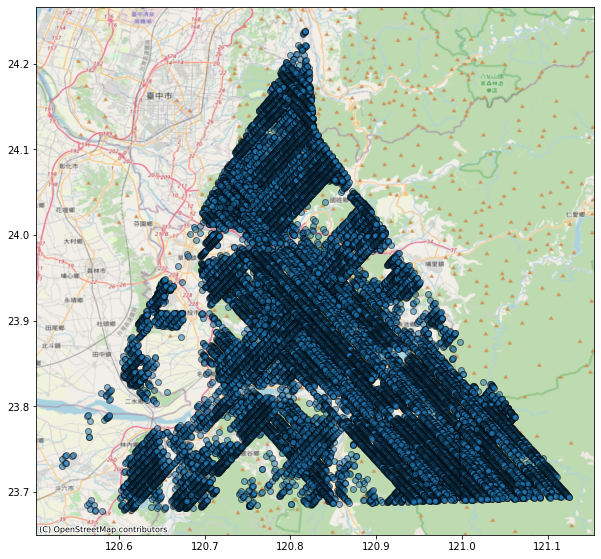

In [13]:
ax = gedi_aoi.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)